# PIC-SURE API tutorial using CureSC database

This is a tutorial notebook, aimed to be quickly up and running with the R PIC-SURE API. It covers the main functionalities of the API.

## PIC-SURE R API 
### What is PIC-SURE? 

<!--img src="./img/PIC-SURE_logo.png" width= "360px"> -->

Databases exposed through PIC-SURE API encompass a wide heterogeneity of architectures and data organizations underneath. PIC-SURE hide this complexity and expose the different databases in the same format, allowing researchers to focus on the analysis and medical insights, thus easing the process of reproducible sciences.

### More about PIC-SURE
PIC-SURE stands for Patient-centered Information Commons: Standardized Unification of Research Elements. The API is available in two different programming languages, python and R, allowing investigators to query databases in the same way using any of those languages.

PIC-SURE is a large project from which the R/python PIC-SURE API is only a brick. Among other things, PIC-SURE also offers a graphical user interface, allowing research scientist to get quick knowledge about variables and data available for a specific data source.

The API is actively developed by the Avillach-Lab at Harvard Medical School.

GitHub repo:
* https://github.com/hms-dbmi/pic-sure-python-adapter-hpds
* https://github.com/hms-dbmi/pic-sure-python-client



 -------   

# Getting your own user-specific security token

**Before running this notebook, please be sure to review the get_your_token.ipynb notebook. It contains explanation about how to get a security token, mandatory to access the databases.**

# Environment set-up

### Pre-requisite
- R 3.5 or later

### Packages installation

In [1]:
list_packages <- c("ggrepel",
                   "jsonlite", 
                   "ggplot2",
                   "plyr",
                   "dplyr",
                   "tidyr",
                   "purrr",
                   "devtools")

for (package in list_packages){
     if(! package %in% installed.packages()){
         install.packages(package, dependencies = TRUE)
     }
     library(package, character.only = TRUE)
}

Loading required package: ggplot2


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘purrr’


The following object is masked from ‘package:plyr’:

    compact


The following object is masked from ‘package:jsonlite’:

    flatten


Loading required package: usethis



#### Installing latest R PIC-SURE API libraries from github

In [2]:
devtools::install_github("hms-dbmi/pic-sure-r-client", force=T)
devtools::install_github("hms-dbmi/pic-sure-r-adapter-hpds", force=T)


✔  checking for file ‘/private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/RtmpyyQWJQ/remotesa1e27dcfd18f/hms-dbmi-pic-sure-r-client-d62fec5/DESCRIPTION’ (425ms)
─  preparing ‘picsure’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘picsure_0.1.0.tar.gz’
   



✔  checking for file ‘/private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/RtmpyyQWJQ/remotesa1e233e35cc5/hms-dbmi-pic-sure-r-adapter-hpds-353b541/DESCRIPTION’
─  preparing ‘hpds’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘hpds_0.1.0.tar.gz’
   


##### Loading user-defined functions

In [3]:
source("R_lib/utils.R")

## Connecting to a PIC-SURE network

Several information are needed to get access to data through the PIC-SURE API: a network URL, a resource id, and a user security token which is specific to a given URL + resource.

In [4]:
PICSURE_network_URL <- "https://curesc.hms.harvard.edu/picsure"
resource_id <- "37663534-6161-3830-6264-323031316539"
token_file <- "token.txt"

In [5]:
my_token <- scan(token_file, what = "character")

In [6]:
connection <- picsure::connect(url = PICSURE_network_URL,
                                 token = my_token)

In [7]:
resource <- hpds::get.resource(connection,
                               resourceUUID = resource_id)

Two objects are created here: a `connection` and a `resource` object, using respectively the `picsure` and `hpds` libraries. 

As we will only be using one single resource, **the `resource` object is actually the only one we will need to proceed with data analysis hereafter** (FYI, the `connection` object is useful to get access to different databases stored in different resources). 

It is connected to the specific data source ID we specified, and enables to query and retrieve data from this source.

## Getting help with the R PIC-SURE API

The `?` operator prints out helper message for any PIC-SURE library function.

In [8]:
?hpds::get.resource()

get.resource {hpds},R Documentation
connection,A PIC-SURE connection object.
resourceUUID,The UUID identity of a Resource hosted via the PIC-SURE connection.
verbose,Flag to display additional runtime information.


## Using the *variables dictionnary*

Once a connection to the desired resource has been established, we first need to get a quick idea of which variables are available in the database. To this end, we will use the `dictionary` method of the `resource` object.

A `dictionary` instance offers the possibility to retrieve matching records according to a specific term, or to retrieve information about all available variables, using the `find.in.dictionary()` function. For instance, looking for variables containing the term 'Smoke' is done this way: 

In [9]:
dictionary_search <- hpds::find.in.dictionary(resource, "Smoke")

Subsequently, objects created by the `find.in.dictionary` exposes the search result using 4 different methods: `extract.count()`, `extract.keys()`, `extract.entries()`, and `extract.DataFrame()`. 

In [12]:
print(list("Count"   = hpds::extract.count(dictionary_search), 
           "Keys"    = hpds::extract.keys(dictionary_search)[1:2],
           "Entries" = hpds::extract.entries(dictionary_search)[1:2]))

$Count
[1] 37

$Keys
[1] "\\SAC\\semtel\\18. Do you live with anyone who currently smokes cigarettes? (not only the place where you live most of the time, but any other place where you also spend the night on a regular basis ie. Grandparents' house, mom's house or dad's house, etc.)\\"                  
[2] "\\SAC\\interimhx\\40. Does the participant LIVE with anyone who currently smokes cigarettes? (not only the place where you live most of the time, but any other place where you also spend the night on a regular basis i.e. Grandparents' house, mom's house or dad's house, etc.)\\"

$Entries
$Entries$...
$Entries$...$name
[1] "\\SAC\\semtel\\18. Do you live with anyone who currently smokes cigarettes? (not only the place where you live most of the time, but any other place where you also spend the night on a regular basis ie. Grandparents' house, mom's house or dad's house, etc.)\\"

$Entries$...$categorical
[1] TRUE

$Entries$...$categoryValues
[1] "No"  "Yes"

$Entries$...$observatio

In [13]:
hpds::extract.dataframe(dictionary_search) %>% tail()

,name,categorical,categoryValues,observationCount,patientCount,HpdsDataType,min,max
,<chr>,<lgl>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>
32,"\SAC\interimhx\45. During the past week, did someone smoke in the participants' presence at work?\",TRUE,"No,Yes",230,222,phenotypes,NA,NA
33,\SIT - Cure Sickle Cell\04 - Arm 3: Observation: Non-Transfusion\M36 (Q12) Annual 3: END\S02r1 Demographic And Phenotypic Information (s02r1_demographic_and_phenotypic_information)\22. Does either the patient or the primary caretaker identify anyone living in the home who smokes or smoked tobacco products in the last 3 years either inside or outside the home?\,TRUE,"No,Yes",16,16,phenotypes,NA,NA
34,"\SAC\ih_form\23. Since the last visit date, has the participant smoked cigarettes?\",TRUE,"No,Yes",264,253,phenotypes,NA,NA
35,\SIT - Cure Sickle Cell\01 - Arm 4: Screening\02 - Re-screening 1\S02r1 Demographic And Phenotypic Information (s02r1_demographic_and_phenotypic_information)\22. Does either the patient or the primary caretaker identify anyone living in the home who smokes or smoked tobacco products in the last 3 years either inside or outside the home?\,TRUE,No,3,3,phenotypes,NA,NA
36,\SAC\ccontrol\12. Has your child smoked cigarettes in the past year?\,TRUE,No,27,27,phenotypes,NA,NA
37,"\SAC\interimhx\39. Since the last visit date, has the participant been exposed to second hand tobacco cigarette, pipe, or cigar smoke?\",TRUE,"No,Yes",229,216,phenotypes,NA,NA


**`hpds::extract.dataframe()` enables to get the result of the dictionary search in a data.frame format.**

The dictionary provide various information about the variables, such as:
- observationCount: number of entries with non-null value
- categorical: type of the variables, True if categorical, False if continuous/numerical
- min/max: only provided for non-categorical variables
- HpdsDataType: 'phenotypes' or 'genotypes'. Currently, the API only expsoses'phenotypes' variables

Hence, it enables to:
* Use the various variables information as criteria for variable selection.
* Use the row names of the DataFrame to get the actual variables names, to be used in the query, as shown below.


Variable names, as currently implemented in the API, aren't straightforward to use.
1. Very long
2. Presence of backslashes that requires modification right after copy-pasting. 

However, using the dictionary to select variables can help to deal with this. Let's say we want to retrieve every variable from the different substudies available in the resource (ie Cure Sickle Cell related studies). Hence, one way to proceed would be to retrieve the whole dictionary for those variables in the form of a data.frame, as below:

In [30]:
plain_variablesDict <- hpds::find.in.dictionary(resource, "SAC") %>% hpds::extract.dataframe()

Moreover, using the `hpds::find.in.dictionary` function without arguments return every entries, as shown in the help documentation. *As for now, this takes a long time in the R PIC-SURE API implementation, and it will probably be fixed in the latter version of the API*

In [31]:
plain_variablesDict[10:20,]

,name,categorical,categoryValues,observationCount,patientCount,HpdsDataType,min,max
,<chr>,<lgl>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>
10,"\SAC\semtel\6. Since the last study visit, has the participant had an attack of wheezing, coughing, shortness of breath or chest tightness after playing hard or exercising?\",TRUE,"No,Yes",67,66,phenotypes,NA,NA
11,\SAC\phlebot\12. Comments on blood drawing/centrifuging\,TRUE,"DNA sample obtained,Difficult blood draw pt c portacath clinic not open today minimal blood obtainted,Difficult veni puncture minimal blood obtained,Difficult venipencture 1cc obtained in tube only. pt did not want additional attempt to obtain more blood,Difficult venipuncture pt veins exhausted - will attempt at next clinic or research visit.,Difficult venipuncture recently d/c from hospital,Difficult venipuncture x 2 pt viens exhausted pt did not want another attempt. no blood obtained this visit. OK to try at subsequent clinic research visit per pt.,Difficult venipunture pt veins exausted two recent hospitalizations,Dificult blood draw minimal blood obtained,Hemalyzed,IgE was no necessary,LDH not obtained,Mother refused to because of religious beliefs,NONE,No LDH obtained because of Hemolyzed sample,No LDH was obtained,Port Accessed in Heme/onc clinic by rn's tolerated well, port flushed / deaccessed,Portacath accessed by clinic RN blood obtained.,centrifuge time missing,difficult Venipuncture parent only wanted one try this time. May attempt again.,difficult venipenture pt viens exhausted to recent surgery and pain admit no blood obtained. pt refused retry,difficult venipuncture pt Veins exhausted recent admit- will try at visit 2,difficult venipuncture, Very small veins. Will obtain cbc results from clinic visit today,difficult venipunture, no blood obtained, pt cooperative; will try at next clinic research visit,drawn from mediport on first attempt without incident; flush required for blood return,missing time,no Blood obtained pt became very tearful and upset. will attempt at next visit. CBC obtained at clinic visit today,no Virgina sample was sent because participant is Chronic tx,no blood obtained poor venous access will attempt to obtain at sebsequent visit.,no blood obtained will attempt at sebsequent visit,no blood obtained- difficult venipuncture will obtain univ of Virginia sample at clinic visit in a month,none,time missing,time missing from centrifuged,total amount not entered; draw tubes sent to a different lab for processing; main centrifuge being serviced,very low hematocrit",61,55,phenotypes,NA,NA
12,\SAC\sleep\Screaming in his/her sleep\,TRUE,"Don't Know,Never (does not happen),No answer,Not Often (<1 night/day a week),Often (3 to 5 nights/days a week),Sometimes (1 to 2 nights/days a week)",197,197,phenotypes,NA,NA
13,\SAC\event\5. Has the participant had a surgical procedure?\,TRUE,"No,Yes",122,102,phenotypes,NA,NA
14,"\SAC\ih_form\6. In the past MONTH, how often has the participant had cough, wheeze, shortness of breath, or chest tightness while exercising or playing?\",TRUE,"10 or more times per month,2 or fewer times per month,3- 4 times per month,5 - 9 times per month",372,253,phenotypes,NA,NA
15,"\SAC\interimhx\12a. If Yes, reason for MRI (check all that apply): (choice=Seizure)\",TRUE,"Checked,Unchecked",224,224,phenotypes,NA,NA
16,\SAC\sleep\Usual Wake Time\,TRUE,"01:00,01:30,02:00,02:30,05:00,05:30,05:40,05:45,06:00,06:15,06:20,06:30,06:40,06:45,06:50,07:00,07:15,07:20,07:30,07:40,07:45,08:00,08:15,08:30,08:45,09:00,09:10,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,15:00,19:00,22:00",390,196,phenotypes,NA,NA
17,\SAC\interimhx\30a. How many times?\,FALSE,NA,29,27,phenotypes,0,6
18,\SAC\ih_form\13. Has the participant had an attack of wheezing that has caused him/her to be short of breath\,TRUE,"No,Yes",319,253,phenotypes,NA,NA


The dictionary currently returned by the API provide various information about the variables, such as:
- observationCount: number of entries with non-null value
- categorical: type of the variables, True if categorical, False if continuous/numerical
- min/max: only provided for non-categorical variables
- HpdsDataType: 'phenotypes' or 'genotypes'. Currently, the API only expsoses'phenotypes' variables

### Parsing variable names

Though helpful, we can use a simple function, `get_multiIndex`, defined in `R_lib/utils.R` to add a little more information and ease working with variables names. 

Although not an official feature of the API, such functionality illustrate how to quickly scan and select groups of related variables.

Printing part of the "parsed names" Dictionary allows to quickly see the tree-like organisation of the variables. Moreover, original and simplified variable names are now stored respectively in the "varName" and "simplified_varName" columns (simplified variable names is simply the last component of the variable name, which usually makes the most sense to know what each variable is about).

In [32]:
# Display the variables tree hierarchy from the variables name
variablesDict <- get_multiIndex_variablesDict(plain_variablesDict)
head(variablesDict)

level_0,level_1,level_2,level_3,level_4,simplified_name,name,observationCount,categorical,categoryValues,nb_modalities,min,max,HpdsDataType
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>,<chr>,<int>,<dbl>,<dbl>,<chr>
SAC,asthma_medication,6c. Stop Date:,NA,NA,6c. Stop Date:,\SAC\asthma_medication\6c. Stop Date:\,8,TRUE,"07/03/2011,10/02/2003,12/05/2012,13/02/2008,25/07/2012,29/08/2012,6/3/2013,9/11/2007",NA,NA,NA,phenotypes
SAC,interimhx,13b.The participant complain of a stiff neck or neck pain during headache?,NA,NA,13b.The participant complain of a stiff neck or neck pain during headache?,\SAC\interimhx\13b.The participant complain of a stiff neck or neck pain during headache?\,31,TRUE,"Never,No answer,Once in a While,With most headaches",NA,NA,NA,phenotypes
SAC,semtel,"11. Since the last visit, has the participant had problems with allergies?",NA,NA,"11. Since the last visit, has the participant had problems with allergies?","\SAC\semtel\11. Since the last visit, has the participant had problems with allergies?\",67,TRUE,"No,Yes",NA,NA,NA,phenotypes
SAC,missvisit,Assessments to be done at rescheduled visit (check all that apply): (choice=Polysomnogram),NA,NA,Assessments to be done at rescheduled visit (check all that apply): (choice=Polysomnogram),\SAC\missvisit\Assessments to be done at rescheduled visit (check all that apply): (choice=Polysomnogram)\,8,TRUE,Unchecked,NA,NA,NA,phenotypes
SAC,interimhx,Other? Specify:,NA,NA,Other? Specify:,\SAC\interimhx\Other? Specify:\,1,TRUE,Visual Eye spots,NA,NA,NA,phenotypes
SAC,interim_meds,2. Medication Start Date,NA,NA,2. Medication Start Date,\SAC\interim_meds\2. Medication Start Date\,20,TRUE,"01/11/2010,02/07/2007,03/03/2008,06/12/2010,08/12/2008,09/07/2012,09/08/2010,10/07/2012,12/04/2007,12/09/2011,15/06/2009,15/11/2010,16/06/2008,17/06/2010,19/12/2011,20/04/2011,20/12/2010,21/09/2009,25/01/2010,26/01/2009",NA,NA,NA,phenotypes


Below is a simple example to illustrate the ease of use a multiIndex dictionary. Let's say we are interested in every variables pertaining to the "Transplant related" of the "CIBMTR" study.

In [45]:
mask_study <- variablesDict[,1] == "SAC"
mask_stroke <- grepl("stroke", variablesDict[["simplified_name"]])
stroke_variables <- variablesDict[mask_study & mask_stroke,]
stroke_variables

level_0,level_1,level_2,level_3,level_4,simplified_name,name,observationCount,categorical,categoryValues,nb_modalities,min,max,HpdsDataType
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>,<chr>,<int>,<dbl>,<dbl>,<chr>
SAC,interimhx,12. Has the participant ever had a diagnosis of a silent stroke?,NA,NA,12. Has the participant ever had a diagnosis of a silent stroke?,\SAC\interimhx\12. Has the participant ever had a diagnosis of a silent stroke?\,86,TRUE,"Don't Know,No,Yes",NA,NA,NA,phenotypes
SAC,interimhx,"12b. If Yes, year of diagnosis of silent stroke",NA,NA,"12b. If Yes, year of diagnosis of silent stroke","\SAC\interimhx\12b. If Yes, year of diagnosis of silent stroke\",18,FALSE,NA,1,20,2011,phenotypes


Although pretty simple, it can be easily combined with other filters to quickly select necessary variables.

## Querying and retrieving data

Beside from the dictionary, the second cornerstone of the API are the `query` functions (`hpds::query.anyof`, `hpds::query.select`, `hpds::query.filter`, `hpds::query.require`). They are the entering point to retrieve data from the resource.

First, we need to create a query object.

In [160]:
my_query <- hpds::new.query(resource = resource)

The query object created will be then be passed to the different query functions to build the query: `hpds::query.anyof`, `hpds::query.select`, `hpds::query.filter`, `hpds::query.require`. Each of those methods accept a query object, a list of variable names, and eventual additional parameters

- The `query.select.add()` method accept variable names as string or list of strings as argument, and will allow the query to return all variables included in the list, without any record (ie subjects/rows) subsetting.

- The `query.require.add()` method accept variable names as string or list of strings as argument, and will allow the query to return all the variables passed, and only records that do not contain any null values for those variables.

- The `query.anyof.add()` method accept variable names as string or list of strings as argument, and will allow the query to return all variables included in the list, and only records that do contain at least one non-null value for those variables.

- The `query.filter.add()` method accept variable names a variable name as strings as argument, plus additional values to filter on that given variable. The query will return this variable and only the records that do match this filter.

All those 4 methods can be combined when building a query. The record eventually returned by the query have to meet all the different specified filters.

### Building the query

Let's say we want to select a cohort from the "SAC study" whom individuals have been exposed to passive tobacco, and for which individuals got a stroke post HCT (Hematopoietic cell transplantation).

In [161]:
# Selecting all variables from "SAC" study
mask_study = variablesDict[["level_0"]] == "SAC"
varnames = variablesDict[mask_study, ]$name %>% as.list()

In [162]:
smoke_simplified <- "40. Does the participant LIVE with anyone who currently smokes cigarettes? (not only the place where you live most of the time, but any other place where you also spend the night on a regular basis i.e. Grandparents' house, mom's house or dad's house, etc.)"
smoke_varname <- variablesDict[variablesDict["simplified_name"] == smoke_simplified, ]$name 

stroke_simplified <- "12. Has the participant ever had a diagnosis of a silent stroke?"
stroke_varname <- variablesDict[variablesDict["simplified_name"] == stroke_simplified, ]$name 
values_stroke <- variablesDict[mask_stroke, "categoryValues"]

In [163]:
hpds::query.require.add(my_query, keys = smoke_varname)
hpds::query.select.add(my_query, keys = varnames)

## Retrieving the data

Once our query object is finally built, we use the `query.run` function to retrieve the data corresponding to our query

In [198]:
my_df <- hpds::query.run(my_query, result.type = "dataframe")

In [199]:
dim(my_df)

[1] 224 696

In [200]:
head(my_df)

Patient.ID,X.SAC.AGE_OF_SUBJECT_AT_VISIT.,X.SAC.EVENT.,X.SAC.STUDY_ARM.,X.SAC.SUBJECT_ID.,X.SAC.asthma_medication.1..Date.of.Chart.Review..,X.SAC.asthma_medication.10..AeroBid...Generic.name..Flunisolide..,X.SAC.asthma_medication.11..Azmacort...Generic.name..Triamcinolone..,X.SAC.asthma_medication.12..Dulera...Generic.name..Mometasone.and.Foromoterol..,X.SAC.asthma_medication.13..Asmanex.Twisthaler...Generic.name..Monetasone..,⋯,X.SAC.sleep.Wets.the.bed.,X.SAC.tonsillectomy.1..Tonsillectomy.,X.SAC.tonsillectomy.3..Adenoidectomy..,X.SAC.tonsillectomy.Date.form.completed..,X.SAC.urine.1..Date.of.urine.collection..,X.SAC.urine.2..Time.of.urine.collection..,X.SAC.urine.3..Approximate.total.amount.of.urine.collected..,X.SAC.urine.4..Comments..if.any...,X.SAC.withdrawal.Date.participant.removed.withdrawn.from.study.,X.SAC.withdrawal.Reason.for.removal.from.study.
<int>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>
10001,NaN,,,3002101,20/11/2013,,,,,⋯,Never (does not happen),,,,2013-05-05,07:30,15,,,
10002,NaN,V1A (Arm 1: Cases-SCD),Arm 1: Cases-SCD,2027101,24/11/2013,,,,,⋯,Never (does not happen),,,,2012-12-27,14:40,90,,,
10003,NaN,,,2088101,16/12/2013,,,,,⋯,Always (6 to 7 nights/days a week),,,,2011-12-28,09:50,80,,,
10004,NaN,,,3042101,05/11/2013,No,No,No,No,⋯,,,,,,,NaN,,,
10008,NaN,,,2042101,06/12/2013,,,,,⋯,Never (does not happen),,,,2011-06-27,14:30,40,,,
10009,NaN,,,1050101,11/21/2013,,,,,⋯,Never (does not happen),,,,2012-02-09,20:11,200,collected 240 mls,,


From this point, we can proceed with the data management and analysis using any other R function or libraries.

In [234]:
# Temporary needed to by
dot_varnames <- parsing_varNames(c(stroke_varname, smoke_varname))
df_plot <- my_df[, dot_varnames]
names(df_plot) <- c("Silent_Stroke", "Passive_Tobacco")
df_plot[df_plot==""] <- NA
df_plot <- df_plot[!is.na(df_plot$Silent_Stroke),]

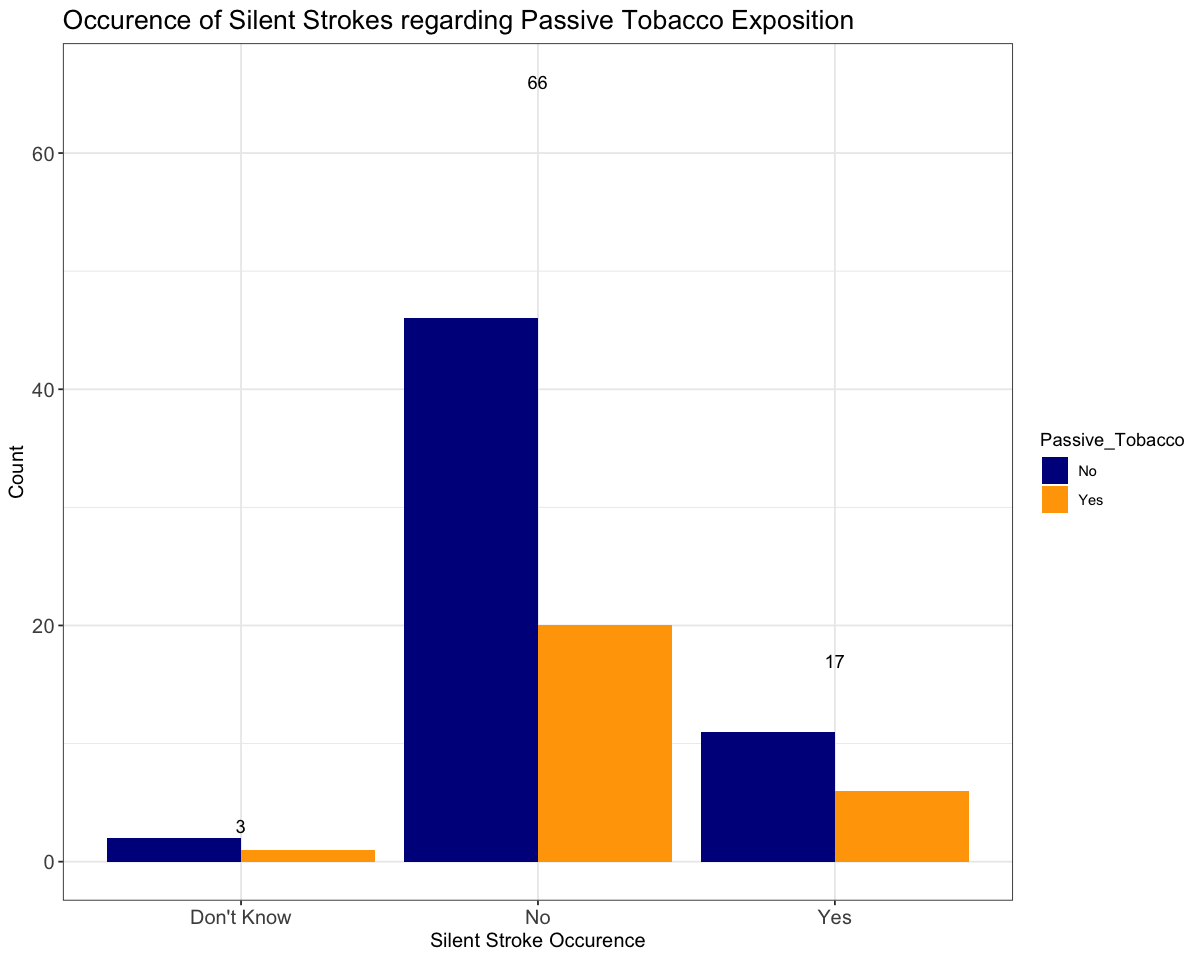

In [242]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(df_plot) + 
geom_bar(aes_string(x = "Silent_Stroke", fill="Passive_Tobacco"), position="dodge") +
scale_fill_manual(values=c("Dark Blue", "Orange")) +
labs(title="Occurence of Silent Strokes regarding Passive Tobacco Exposition", 
    x="Silent Stroke Occurence",
    y="Count") + 
theme_bw() +
theme(axis.text = element_text(size=12),
     axis.title = element_text(size=12),
     plot.title = element_text(size=16))